In [67]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_selector, ColumnTransformer
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from plotnine import ggplot, aes, geom_line, geom_abline, labs, coord_flip, theme, geom_bar
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from sklearn.metrics import cohen_kappa_score, make_scorer
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

In [48]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [49]:
ha['restecg'] = ha['restecg'].astype('object')
ha['cp'] = ha['cp'].astype('object')

In [50]:
ha

age  sex cp  trtbps  chol restecg  thalach  output
0     63    1  3     145   233       0      150       1
1     37    1  2     130   250       1      187       1
2     56    1  1     120   236       1      178       1
3     57    0  0     120   354       1      163       1
4     57    1  0     140   192       1      148       1
..   ...  ... ..     ...   ...     ...      ...     ...
268   59    1  0     164   176       0       90       0
269   57    0  0     140   241       1      123       0
270   45    1  3     110   264       1      132       0
271   68    1  0     144   193       1      141       0
272   57    0  1     130   236       0      174       0

[273 rows x 8 columns]

In [51]:
X = ha.drop(['output'], axis=1)
y=ha['output']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25)

In [53]:
ct = ColumnTransformer(
  [
    ("dummify",
    OneHotEncoder(sparse_output = False, handle_unknown='ignore'),
    make_column_selector(dtype_include=object)),
    ("standardize",
    StandardScaler(),
    make_column_selector(dtype_include=np.number))
  ],
  remainder = "passthrough"
)

# Part One: Fitting Models

## KNN

In [54]:
knn= KNeighborsClassifier()

my_pipeline = Pipeline(
    [('preprocessing',ct),('KNN',knn)]
)

neighbors = {'KNN__n_neighbors':[2,5,10,25,50, 100, 200]}

gscv = GridSearchCV(my_pipeline, neighbors, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

results = pd.DataFrame(data = {"neighbors": [2,5,10,25,50, 100, 200], "KNN Scores": gscv_fitted.cv_results_['mean_test_score']})
results

neighbors  KNN Scores
0          2    0.765565
1          5    0.801109
2         10    0.830823
3         25    0.838136
4         50    0.843348
5        100    0.836755
6        200    0.810113

Cross validated AUC: 0.8433

Fit the Final Model:

In [55]:
knn= KNeighborsClassifier(n_neighbors=50)

my_knn_pipeline = Pipeline(
    [('preprocessing',ct),('KNN',knn)]
)

fitted_knn_pipeline=my_pipeline.fit(X_train, y_train)
y_knn_preds=fitted_knn_pipeline.predict(X_test)

Confusion Matrix

In [56]:
cm = confusion_matrix(y_test, fitted_knn_pipeline.predict(X_test))
print(cm)

[[20  6]
 [ 9 34]]


## Logistic Regression

In [57]:
lr = LogisticRegression(penalty = 'elasticnet', solver='saga')

my_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

vals = {'Log__C':[0.001,0.01,0.1,1,10, 25, 50, 100],
           'Log__l1_ratio':[0.001,0.01,0.1,0.25,0.5,0.75]}

gscv = GridSearchCV(my_pipeline, vals, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

results_df = pd.DataFrame(gscv_fitted.cv_results_)
results_df = results_df[['param_Log__C', 'param_Log__l1_ratio', 'mean_test_score']]

results_df.rename(columns={
    'param_Log__C': 'lambda',
    'param_Log__l1_ratio': 'alpha',
    'mean_test_score': 'roc_auc'
}, inplace=True)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
/usr/local/lib/python3.10/dist-packages/sklearn/line

In [58]:
sorted_results_df = results_df.sort_values(by='roc_auc', ascending=False)

# Get the row with the highest roc_auc
best_row = sorted_results_df.iloc[0]

# Print the combination of lambda and alpha with the highest roc auc
print(f"The best combination is lambda = {best_row['lambda']} and alpha = {best_row['alpha']} with a ROC AUC of {best_row['roc_auc']:.4f}")

The best combination is lambda = 0.1 and alpha = 0.001 with a ROC AUC of 0.8686


The Final Model:

In [59]:
lr = LogisticRegression(penalty = 'elasticnet', solver='saga', C=0.1, l1_ratio=0.001)

my_lr_pipeline = Pipeline(
    [('preprocessing',ct),('Log',lr)]
)

fitted_lr_pipeline=my_lr_pipeline.fit(X_train, y_train)
y_lr_preds=fitted_lr_pipeline.predict(X_test)

Confusion Matrix:

In [60]:
cm = confusion_matrix(y_test, fitted_lr_pipeline.predict(X_test))
print(cm)

[[20  6]
 [ 7 36]]


Coefficients:

In [63]:
feature_names = fitted_lr_pipeline.named_steps['preprocessing'].get_feature_names_out()
coefficients = fitted_lr_pipeline.named_steps['Log'].coef_

coefficients = coefficients[0]

coef_df = pd.DataFrame({
    'Variable': feature_names,
    'Coefficient': coefficients
})
coef_df['abs'] = abs(coef_df['Coefficient'])
coef_df=coef_df.sort_values(by='abs', ascending=False)

In [64]:
coef_df


Variable  Coefficient       abs
0          dummify__cp_0    -0.796257  0.796257
11  standardize__thalach     0.707517  0.707517
8       standardize__sex    -0.540464  0.540464
2          dummify__cp_2     0.413307  0.413307
1          dummify__cp_1     0.333189  0.333189
5     dummify__restecg_1     0.190643  0.190643
10     standardize__chol    -0.167305  0.167305
4     dummify__restecg_0    -0.149694  0.149694
7       standardize__age    -0.117452  0.117452
9    standardize__trtbps    -0.094153  0.094153
3          dummify__cp_3     0.047980  0.047980
6     dummify__restecg_2    -0.039728  0.039728

There are some key results regarding the input variables:


*   Sex has a significantly negative coefficients. The documentation did not give details on which sex 1 and 0 corresponded to, however, so a strong conclusion cannot be made.
*   Having typical angina chest pain had the highest valued coefficient.
*  The maximum heart rate achieved during exercise is also very important.



## Decision Tree

In [68]:
det = DecisionTreeClassifier()

my_pipeline = Pipeline(
    [('preprocessing',ct),('DecTrees',det)]
)

neighbors = {'DecTrees__min_impurity_decrease':[0.001,0.01,0.05,0.1,0.5]}

gscv = GridSearchCV(my_pipeline, neighbors, cv = 5, scoring='roc_auc')

gscv_fitted = gscv.fit(X, y)

results = pd.DataFrame(data = {"MinImpurityDecrease": [0.001,0.01,0.05,0.1,0.5], "DT Scores": gscv_fitted.cv_results_['mean_test_score']})
results

MinImpurityDecrease  DT Scores
0                0.001   0.694874
1                0.010   0.767304
2                0.050   0.753333
3                0.100   0.753333
4                0.500   0.500000

Cross validated ROC AUC: 0.767304

Final Model

In [69]:
det = DecisionTreeClassifier(min_impurity_decrease=0.01)

my_det_pipeline = Pipeline(
    [('preprocessing',ct),('DecTrees',det)]
)

fitted_det_pipeline=my_det_pipeline.fit(X_train, y_train)
y_det_preds=fitted_det_pipeline.predict(X_test)

Confusion Matrix

In [70]:
cm = confusion_matrix(y_test, fitted_det_pipeline.predict(X_test))
print(cm)

[[19  7]
 [12 31]]


Coefficients

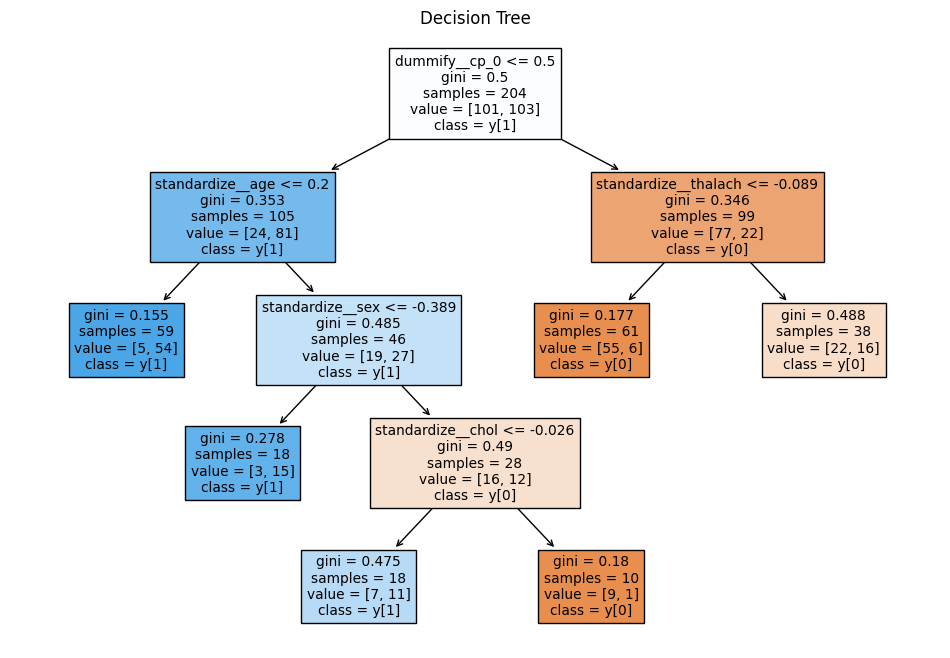

In [71]:
# Extract the decision tree model from the pipeline
decision_tree_model = fitted_det_pipeline.named_steps['DecTrees']

# Plot the decision tree
plt.figure(figsize=(12, 8))  # Adjust the size as needed
plot_tree(decision_tree_model, filled=True, feature_names=feature_names, class_names=True)
plt.title("Decision Tree")
plt.show()

##Interpretation

Maximum heart rate achieved, chest pain, and sex were the most important for predicting heart attack risk. Age was also very important in the decision tree model.

## ROC Curve

### KNN

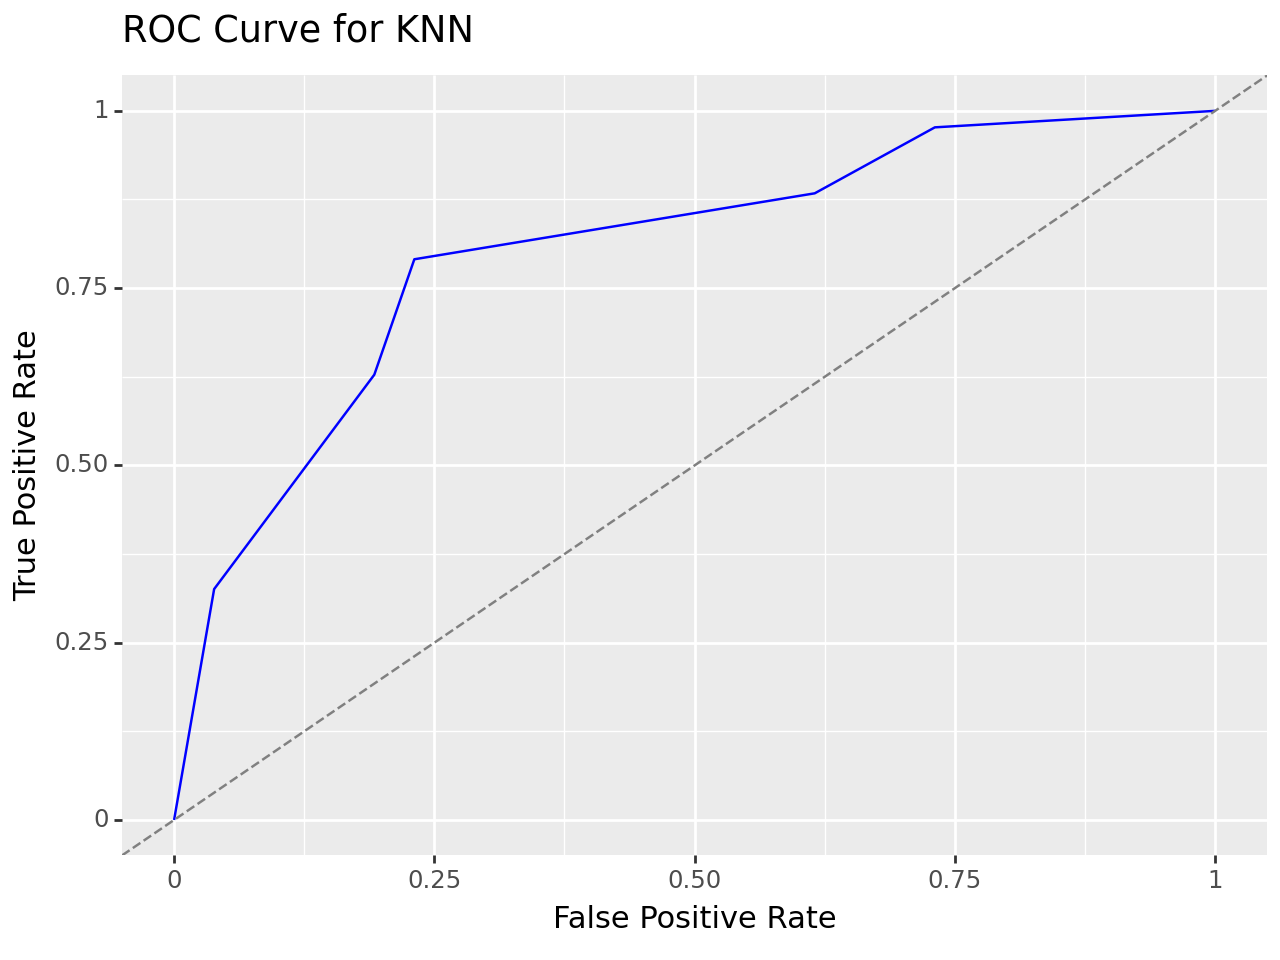

In [72]:
y_probs = fitted_knn_pipeline.predict_proba(X_test)
positive_probs = y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, positive_probs)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})


roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR')) +
    geom_line(color='blue') +
    geom_abline(linetype='dashed', color='gray') +
    labs(title='ROC Curve for KNN', x='False Positive Rate', y='True Positive Rate')
)

print(roc_plot)

### Logistic Regression

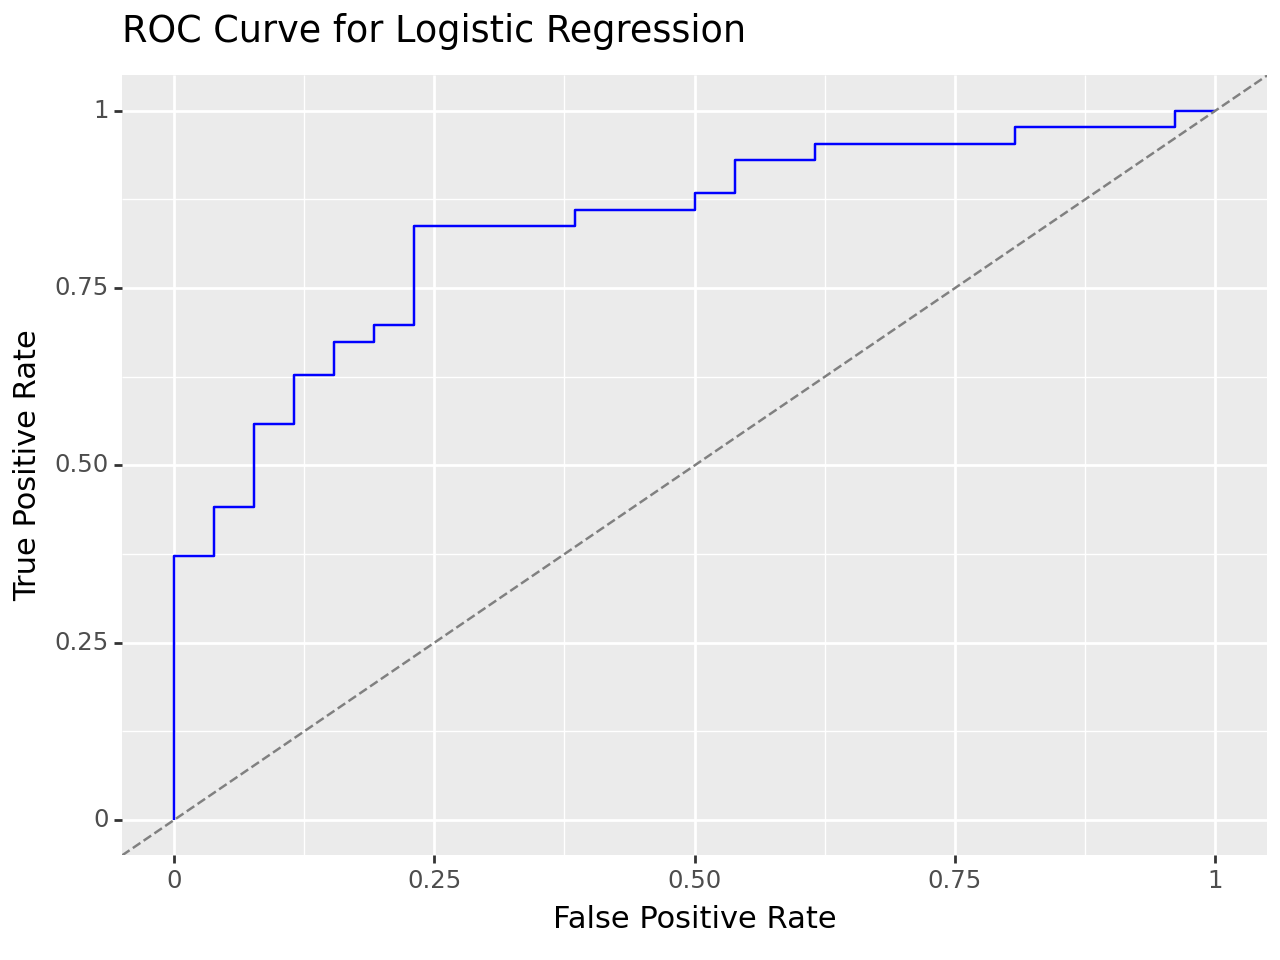

In [73]:
y_probs = fitted_lr_pipeline.predict_proba(X_test)
positive_probs = y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, positive_probs)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})


roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR')) +
    geom_line(color='blue') +
    geom_abline(linetype='dashed', color='gray') +
    labs(title='ROC Curve for Logistic Regression', x='False Positive Rate', y='True Positive Rate')
)

print(roc_plot)

### Decision Trees

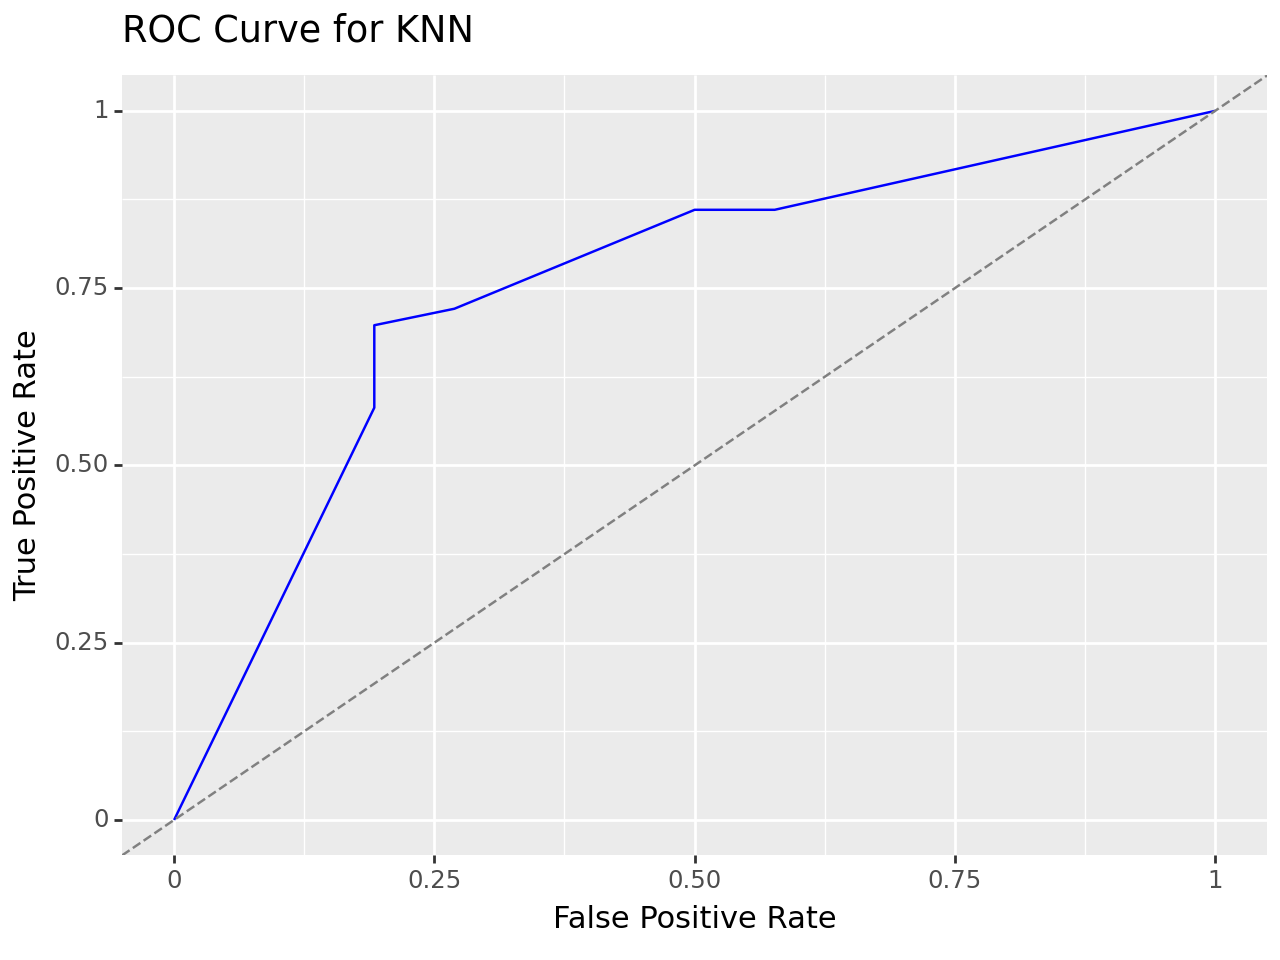

In [74]:
y_probs = fitted_det_pipeline.predict_proba(X_test)
positive_probs = y_probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, positive_probs)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr, 'Threshold': thresholds})


roc_plot = (
    ggplot(roc_df, aes(x='FPR', y='TPR')) +
    geom_line(color='blue') +
    geom_abline(linetype='dashed', color='gray') +
    labs(title='ROC Curve for KNN', x='False Positive Rate', y='True Positive Rate')
)

print(roc_plot)

# Part 2: Metrics

## True Positive Rate or Recall or Sensitivity

In [77]:
#KNN
knnRecall = cross_val_score(fitted_knn_pipeline, X, y, cv = 5, scoring = 'recall')
print("KNN: ",np.mean(knnRecall))

#LR
lrRecall = cross_val_score(fitted_lr_pipeline, X, y, cv = 5, scoring = 'recall')
print("LR: ",np.mean(lrRecall))

#DET
detRecall = cross_val_score(fitted_det_pipeline, X, y, cv = 5, scoring = 'recall')
print("DET: ",np.mean(detRecall))

KNN:  0.7611494252873563
LR:  0.822528735632184
DET:  0.7535632183908045


## Precision or Positive Predictive Value

In [78]:
#KNN
knnP = cross_val_score(fitted_knn_pipeline, X, y, cv = 5, scoring = 'precision')
print("KNN: ",np.mean(knnP))

#LR
lrP = cross_val_score(fitted_lr_pipeline, X, y, cv = 5, scoring = 'precision')
print("LR: ",np.mean(lrP))

#DET
detP = cross_val_score(fitted_det_pipeline, X, y, cv = 5, scoring = 'precision')
print("DET: ",np.mean(detP))

KNN:  0.7539265734265734
LR:  0.7818488917306052
DET:  0.7891900091010213


## True Negative Rate or Specificity or Negative Predictive Value

In [79]:
specificity = make_scorer(recall_score, pos_label=0)

#KNN
knnspec=cross_val_score(fitted_knn_pipeline, X_train, y_train, cv=10, scoring=specificity)
print("KNN: ",np.mean(knnspec))

#LR
lrspec = cross_val_score(fitted_lr_pipeline, X, y, cv = 5, scoring = specificity)
print("LR: ",np.mean(lrspec))

#DET
detspec = cross_val_score(fitted_det_pipeline, X, y, cv = 5, scoring = specificity)
print("DET: ",np.mean(detspec))

KNN:  0.7136363636363636
LR:  0.7227692307692308
DET:  0.7627692307692308


## Accuracy

In [80]:
#KNN
knn = cross_val_score(fitted_knn_pipeline, X, y, cv = 5, scoring = 'accuracy')
knna = np.mean(knn)

#LR
lr = cross_val_score(fitted_lr_pipeline, X, y, cv = 5, scoring = 'accuracy')
lra = np.mean(lr)

#DET
det = cross_val_score(fitted_det_pipeline, X, y, cv = 5, scoring = 'accuracy')
deta = np.mean(det)

In [81]:
results_df = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Decision Tree'],
    'Specificity': [np.mean(knnspec), np.mean(lrspec), np.mean(detspec)],
    'Precision': [np.mean(knnP), np.mean(lrP), np.mean(detP)],
    'Recall': [np.mean(knnRecall), np.mean(lrRecall), np.mean(detRecall)],
    'Accuracy':[knna,lra,deta]
})

results_df

Model  Specificity  Precision    Recall  Accuracy
0                  KNN     0.713636   0.753927  0.761149  0.736364
1  Logistic Regression     0.722769   0.781849  0.822529  0.776431
2        Decision Tree     0.762769   0.789190  0.753563  0.758114

# Part 3: Discussion

Q1: I would use recall, because high recall reduces the chance of incorrectly classifying high risk patients as low risk. For this, I would use Logistic Regression, which had the highest Recall, and would expect a value of 0.823.

Q2: I would use precision, because high precision would ensure that most patients classified as high risk truly needed a bed.For this, I would use Decision Trees, which had the highest precision, and I would expect a value of 0.789

Q3: I would use a model that had feature importance, so I would use Logistic Regression, and measure the values of the coefficients. I would expect, based on my logistic regression model, that typical angina would have the largest measure of -0.796, followed by maximum heart rate achieved during exercise at 0.708.

Q4: I would use accuracy, because it gives a general sense of how often the algorithm is correct. For this, I would use Logistic regression, which had the highest accuracy, and I would expect a value of 0.776

# Part 4: Validation

In [96]:
ha_validation = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")

In [97]:
ha_validation['restecg'] = ha_validation['restecg'].astype('object')
ha_validation['cp'] = ha_validation['cp'].astype('object')

In [98]:
vX = ha_validation.drop(['output'],axis=1)
vy = ha_validation['output']

## KNN

In [99]:
fitted_knn_pipeline=my_knn_pipeline.fit(X_train, y_train)
y_knn_preds=fitted_knn_pipeline.predict(vX)

cm = confusion_matrix(vy, y_knn_preds)
print(cm)

[[ 9  2]
 [ 9 10]]


In [100]:
kroc_auc = roc_auc_score(vy, y_knn_preds)
kprecision = precision_score(vy, y_knn_preds)
krecall = recall_score(vy, y_knn_preds)

print(f'ROC AUC: {kroc_auc}')
print(f'Precision: {kprecision}')
print(f'Recall: {krecall}')

ROC AUC: 0.6722488038277511
Precision: 0.8333333333333334
Recall: 0.5263157894736842


##Logistic Regression

In [101]:
fitted_lr_pipeline=my_lr_pipeline.fit(X_train, y_train)
y_lr_preds=fitted_lr_pipeline.predict(vX)

cm = confusion_matrix(vy, y_lr_preds)
print(cm)

[[ 9  2]
 [ 5 14]]


In [102]:
lroc_auc = roc_auc_score(vy, y_lr_preds)
lprecision = precision_score(vy, y_lr_preds)
lrecall = recall_score(vy, y_lr_preds)

print(f'ROC AUC: {lroc_auc}')
print(f'Precision: {lprecision}')
print(f'Recall: {lrecall}')

ROC AUC: 0.777511961722488
Precision: 0.875
Recall: 0.7368421052631579


## Decision Trees

In [103]:
fitted_det_pipeline=my_det_pipeline.fit(X_train, y_train)
y_det_preds=fitted_det_pipeline.predict(vX)

cm = confusion_matrix(vy, y_det_preds)
print(cm)

[[11  0]
 [ 6 13]]


In [104]:
droc_auc = roc_auc_score(vy, y_det_preds)
dprecision = precision_score(vy, y_det_preds)
drecall = recall_score(vy, y_det_preds)

print(f'ROC AUC: {droc_auc}')
print(f'Precision: {dprecision}')
print(f'Recall: {drecall}')

ROC AUC: 0.8421052631578947
Precision: 1.0
Recall: 0.6842105263157895


In [105]:
new_results_df = pd.DataFrame({
    'Model': ['kNN', 'Logistic Regression', 'Decision Trees'],
    'new ROC AUC': [kroc_auc, lroc_auc, droc_auc],
    'new Precision': [kprecision, lprecision, dprecision],
    'new Recall': [krecall, lrecall, drecall]
})

new_results_df

Model  new ROC AUC  new Precision  new Recall
0                  kNN     0.672249       0.833333    0.526316
1  Logistic Regression     0.777512       0.875000    0.736842
2       Decision Trees     0.842105       1.000000    0.684211

In [106]:
results_df

Model  Specificity  Precision    Recall  Accuracy
0                  KNN     0.713636   0.753927  0.761149  0.736364
1  Logistic Regression     0.722769   0.781849  0.822529  0.776431
2        Decision Tree     0.762769   0.789190  0.753563  0.758114

My measures of model success, in terms of precision and recall, were relatively correct. Using the validation data I still got the highest precision from decision trees and the highest recall from logistic regression.

# Part 5: Cohen's Kappa

Cohen's Kappa is a statistical measure used to evaluate the accuracy of a classification model by comparing its predictions against a baseline accuracy, which is the accuracy that could be achieved by random chance. It's particularly useful in scenarios where you want to account for the possibility that the model might be making correct predictions by mere luck, especially in cases with imbalanced class distributions.

In [107]:
kappa_scorer = make_scorer(cohen_kappa_score)

#KNN
knnspec=cross_val_score(fitted_knn_pipeline, X_train, y_train, cv=10, scoring=kappa_scorer)
print("KNN: ",np.mean(knnspec))

#LR
lrspec = cross_val_score(fitted_lr_pipeline, X, y, cv = 5, scoring = kappa_scorer)
print("LR: ",np.mean(lrspec))

#DET
detspec = cross_val_score(fitted_det_pipeline, X, y, cv = 5, scoring = kappa_scorer)
print("DET: ",np.mean(detspec))


KNN:  0.5218072327321206
LR:  0.5480725720578155
DET:  0.515052858758607


Using Cohen's Kappa on the original data, Logistic Regression performed the best. This makes sense, as it is simpler and less prone to overfitting which means it generalizes better to new data and can result in a higher COhen's Kappa score.